# Level 4: Network Analysis

**Мета:** Побудова графів зв'язків між учасниками закупівель для виявлення підозрілих структур (картелів, монопольних відносин).

## Типи графів:

| Тип графа | Вузли | Ребра | Що виявляє |
|-----------|-------|-------|------------|
| **Winner-Loser** | bidder_id | Переможець → Програвший | Bid-rigging rings |
| **Buyer-Supplier** | buyer_id, supplier_id | Контракт | Монопольні відносини |
| **Bidder Co-participation** | bidder_id | Спільна участь | Потенційні картелі |
| **Full Collusion Graph** | bidder + supplier + buyer | Всі зв'язки | Комплексні схеми |

## Метрики мережі:

| Метрика | Що показує | Інтерпретація аномалії |
|---------|------------|------------------------|
| Community detection (Louvain) | Групи тісно пов'язаних учасників | Потенційні картелі |
| Betweenness centrality | Вузли-посередники | Координатори змов |
| Clustering coefficient | Щільність локальних зв'язків | Замкнуті групи |
| Degree distribution | Розподіл кількості зв'язків | Аномально активні учасники |

In [2]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from itertools import combinations
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import load_tenders, load_bids, load_buyers, load_suppliers, load_bidders
from src.detectors import NetworkAnalysisDetector

# ============================================================
# CONFIGURATION
# ============================================================
YEARS = [2022, 2023, 2024, 2025]
MIN_CO_BIDS = 3           # Мінімум спільних тендерів для ребра
MIN_CONTRACTS = 3         # Мінімум контрактів для buyer-supplier ребра
MIN_COMMUNITY_SIZE = 3    # Мінімальний розмір community
BUILD_FULL_COLLUSION = True  # Build full collusion graph (slow)
# ============================================================

# Create output directories
Path('../results/figures/network').mkdir(parents=True, exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print(f"Configuration:")
print(f"  YEARS = {YEARS}")
print(f"  MIN_CO_BIDS = {MIN_CO_BIDS}")
print(f"  MIN_CONTRACTS = {MIN_CONTRACTS}")
print(f"  BUILD_FULL_COLLUSION = {BUILD_FULL_COLLUSION}")

Configuration:
  YEARS = [2022, 2023, 2024, 2025]
  MIN_CO_BIDS = 3
  MIN_CONTRACTS = 3
  BUILD_FULL_COLLUSION = True


## 1. Завантаження даних

In [10]:
print("Loading data...")
tenders = load_tenders(years=YEARS)
bids = load_bids(years=YEARS)
buyers = load_buyers()
suppliers = load_suppliers()
bidders = load_bidders()

print(f"\nDataset:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Bids: {len(bids):,}")
print(f"  Buyers: {len(buyers):,}")
print(f"  Suppliers: {len(suppliers):,}")
print(f"  Bidders: {len(bidders):,}")

Loading data...
Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Scanning bids 2022...
Scanning bids 2023...
Scanning bids 2024...
Scanning bids 2025...
Loaded 2,639,473 bids
Loaded buyers: 35,995
Loaded suppliers: 358,376
Loaded bidders: 72,291

Dataset:
  Tenders: 12,877,960
  Bids: 2,639,473
  Buyers: 35,995
  Suppliers: 358,376
  Bidders: 72,291


In [11]:
# Filter to competitive tenders (Open/Selective with 2+ bidders)
competitive_tenders = tenders[
    (tenders['procurement_method'].isin(['open', 'selective'])) &
    (tenders['number_of_tenderers'] >= 2)
].copy()

print(f"Competitive tenders: {len(competitive_tenders):,} ({len(competitive_tenders)/len(tenders)*100:.1f}%)")

# Filter bids to competitive tenders
bids_competitive = bids[bids['tender_id'].isin(competitive_tenders['tender_id'])].copy()
print(f"Bids in competitive tenders: {len(bids_competitive):,}")

Competitive tenders: 575,750 (4.5%)
Bids in competitive tenders: 2,054,727


## 2. Graph 1: Bidder Co-participation (Cartel Detection)

**Вузли:** bidder_id  
**Ребра:** Спільна участь у тендері  
**Що виявляє:** Потенційні картелі - групи постачальників, що систематично беруть участь разом

In [11]:
# Run Network Analysis using detector class
print("Running Network Analysis Detector...")

network_detector = NetworkAnalysisDetector(
    min_co_bids=MIN_CO_BIDS,
    min_contracts=MIN_CONTRACTS,
    min_community_size=MIN_COMMUNITY_SIZE,
    # Stricter anomaly thresholds
    suspicious_min_degree=10,
    suspicious_min_clustering=0.7,
    rotation_min_ratio=0.7,
    rotation_min_interactions=5,
    monopoly_min_ratio=0.9,
    monopoly_min_contracts=20,
    # Full collusion graph (slow, optional)
    build_full_collusion=True
)

# Run detection
network_results = network_detector.fit_detect(
    tenders,
    bids_df=bids,
    bidders_df=bidders,
)

print("\nNetwork Analysis complete!")
print(network_detector.summary().to_string(index=False))

Running Network Analysis Detector...
Processing 12,877,960 tenders...
  Competitive tenders: 575,750
  Bids in competitive: 2,054,727

Step 1/5: Building co-bidding network...
    Nodes: 20,894
    Edges: 170,763
Step 2/5: Detecting communities...
    Using igraph (fast)...
    Communities: 836
Step 3/5: Building winner-loser network...
    Nodes: 15,633
    Edges: 95,300
    Bid rotation pairs: 13615
Step 4/5: Building buyer-supplier network...
    Nodes: 198,182
    Edges: 916,277
    Monopolistic pairs (>=80%, >=10 contracts): 172
Step 5/5: Building full collusion graph...
    Full collusion graph:
      Nodes: 201,879
      Edges: 1,087,106
    Detecting communities in full collusion graph...
      Total communities: 364
      Mixed communities (buyers + suppliers): 124

Computing tender-level results...
    Suspicious suppliers: 1636
    Strict monopolistic pairs: 44
    Strict rotation pairs: 7962

Network Analysis complete!
  Tenders with network flags: 2,296,664

Network Analys

In [16]:
# Community detection results from detector
G_cobid = network_detector.G_cobid
partition = network_detector.cobid_communities

if partition:
    # Count communities
    community_counts = pd.Series(partition).value_counts()
    n_communities = len(community_counts)

    print(f"Communities found: {n_communities}")
    print(f"Largest community: {community_counts.iloc[0]} bidders")
    print(f"Communities with 3+ bidders: {len(community_counts[community_counts >= 3])}")
else:
    print("No communities found")
    community_counts = pd.Series()

Communities found: 836
Largest community: 3134 bidders
Communities with 3+ bidders: 262


In [14]:
# Network metrics from detector
cobid_metrics = network_detector.cobid_metrics

if cobid_metrics is not None and len(cobid_metrics) > 0:
    # Degree distribution
    degree_df = cobid_metrics[['bidder_id', 'degree']].sort_values('degree', ascending=False)
    
    print(f"\nDEGREE DISTRIBUTION (co-bidding partners):")
    print(f"  Max: {degree_df['degree'].max()}")
    print(f"  Mean: {degree_df['degree'].mean():.1f}")
    print(f"  Median: {degree_df['degree'].median():.0f}")
    
    # Top bidders by degree (most connected)
    print(f"\nTOP 10 MOST CONNECTED BIDDERS:")
    top_degree = degree_df.head(10).merge(
        suppliers[['supplier_id', 'supplier_name']].rename(columns={'supplier_id': 'bidder_id'}),
        on='bidder_id', how='left'
    )
    for _, row in top_degree.iterrows():
        name = row['supplier_name'][:50] if pd.notna(row.get('supplier_name')) else 'N/A'
        print(f"  {row['degree']:>4} partners: {name}")
else:
    print("No metrics computed")
    degree_df = pd.DataFrame()


DEGREE DISTRIBUTION (co-bidding partners):
  Max: 2281
  Mean: 16.3
  Median: 4

TOP 10 MOST CONNECTED BIDDERS:
  2281 partners: Невідокремлений структурний підрозділ ТОВ "Епіцент
   779 partners: ТОВ "ВОК - Медіка Груп"
   704 partners: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІСПОЛІН П
   677 partners: ТОВ "ТВГ УКРАЇНСЬКИЙ ПАПІР"
   649 partners: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ «СПАРТА 20
   577 partners: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАВОЛГА"
   574 partners: ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕНДЕРМЕД"
   560 partners: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРАЇНА ВІ
   542 partners: ФІЗИЧНА ОСОБА-ПІДПРИЄМЕЦЬ Кутенкова Ольга Олександ
   540 partners: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТЛАНТ БУ


In [ ]:
# Betweenness centrality from detector metrics
# NOTE: Co-bidding graph has 836 connected components, so global betweenness
# normalization divides by (N-1)(N-2)/2 ≈ 218M, making all values ≈ 0.
# This is a known structural limitation (see thesis section 3.6.4).
if cobid_metrics is not None and len(cobid_metrics) > 0:
    betweenness_df = cobid_metrics[['bidder_id', 'betweenness']].sort_values('betweenness', ascending=False)
    nonzero = (betweenness_df['betweenness'] > 0).sum()
    
    print(f"BETWEENNESS CENTRALITY:")
    print(f"  Non-zero values: {nonzero} / {len(betweenness_df)}")
    print(f"  Max: {betweenness_df['betweenness'].max():.6f}")
    print(f"\n  ⚠ Betweenness is near-zero for all nodes due to graph fragmentation")
    print(f"  (836 components — normalization by full graph size makes values negligible)")
    print(f"  → Using degree + clustering instead for anomaly detection")
else:
    print("No betweenness metrics available")
    betweenness_df = pd.DataFrame()

In [22]:
# Clustering coefficient from detector metrics
if cobid_metrics is not None and len(cobid_metrics) > 0:
    clustering_df = cobid_metrics[['bidder_id', 'clustering']].sort_values('clustering', ascending=False)
    
    # High clustering + high degree = tightly connected group (potential cartel)
    suspicious_bidders = cobid_metrics[
        (cobid_metrics['degree'] >= 5) &  # At least 5 partners
        (cobid_metrics['clustering'] >= 0.5)  # Partners also connected to each other
    ].sort_values(['clustering', 'degree'], ascending=[False, False])
    
    print(f"\nSUSPICIOUS BIDDERS (high degree + high clustering):")
    print(f"Found: {len(suspicious_bidders)} bidders in tightly connected groups")
    
    if len(suspicious_bidders) > 0:
        suspicious_with_names = suspicious_bidders.head(10).merge(
            suppliers[['supplier_id', 'supplier_name']].rename(columns={'supplier_id': 'bidder_id'}),
            on='bidder_id', how='left'
        )
        for _, row in suspicious_with_names.iterrows():
            name = row['supplier_name'][:40] if pd.notna(row.get('supplier_name')) else 'N/A'
            print(f"  Degree: {row['degree']:>3}, Clustering: {row['clustering']:.2f} - {name}")
else:
    print("No clustering metrics available")
    suspicious_bidders = pd.DataFrame()


SUSPICIOUS BIDDERS (high degree + high clustering):
Found: 5394 bidders in tightly connected groups
  Degree:  25, Clustering: 1.00 - ТОВ "СИСТЕМИ ЕНЕРГОПОСТАЧАННЯ"
  Degree:  24, Clustering: 1.00 - ДП "ПРОФІТ ХАБ" ЧЕРНІГІВСЬКОЇ РЕГІОНАЛЬН
  Degree:  23, Clustering: 1.00 - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
  Degree:  22, Clustering: 1.00 - ФОП Лепко Вікторія Михайлівна
  Degree:  18, Clustering: 1.00 - N/A
  Degree:  17, Clustering: 1.00 - ЧЕРЕВКО ГЕЛЕНА ЛЮДВИКІВНА
  Degree:  17, Clustering: 1.00 - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
  Degree:  17, Clustering: 1.00 - N/A
  Degree:  16, Clustering: 1.00 - ФОП "ЄРЕМЕНКО ОЛЕНА ВАДИМІВНА"
  Degree:  16, Clustering: 1.00 - ФОЗЕКОШ ВАСИЛЬ МИХАЙЛОВИЧ


Visualizing co-bidding network...


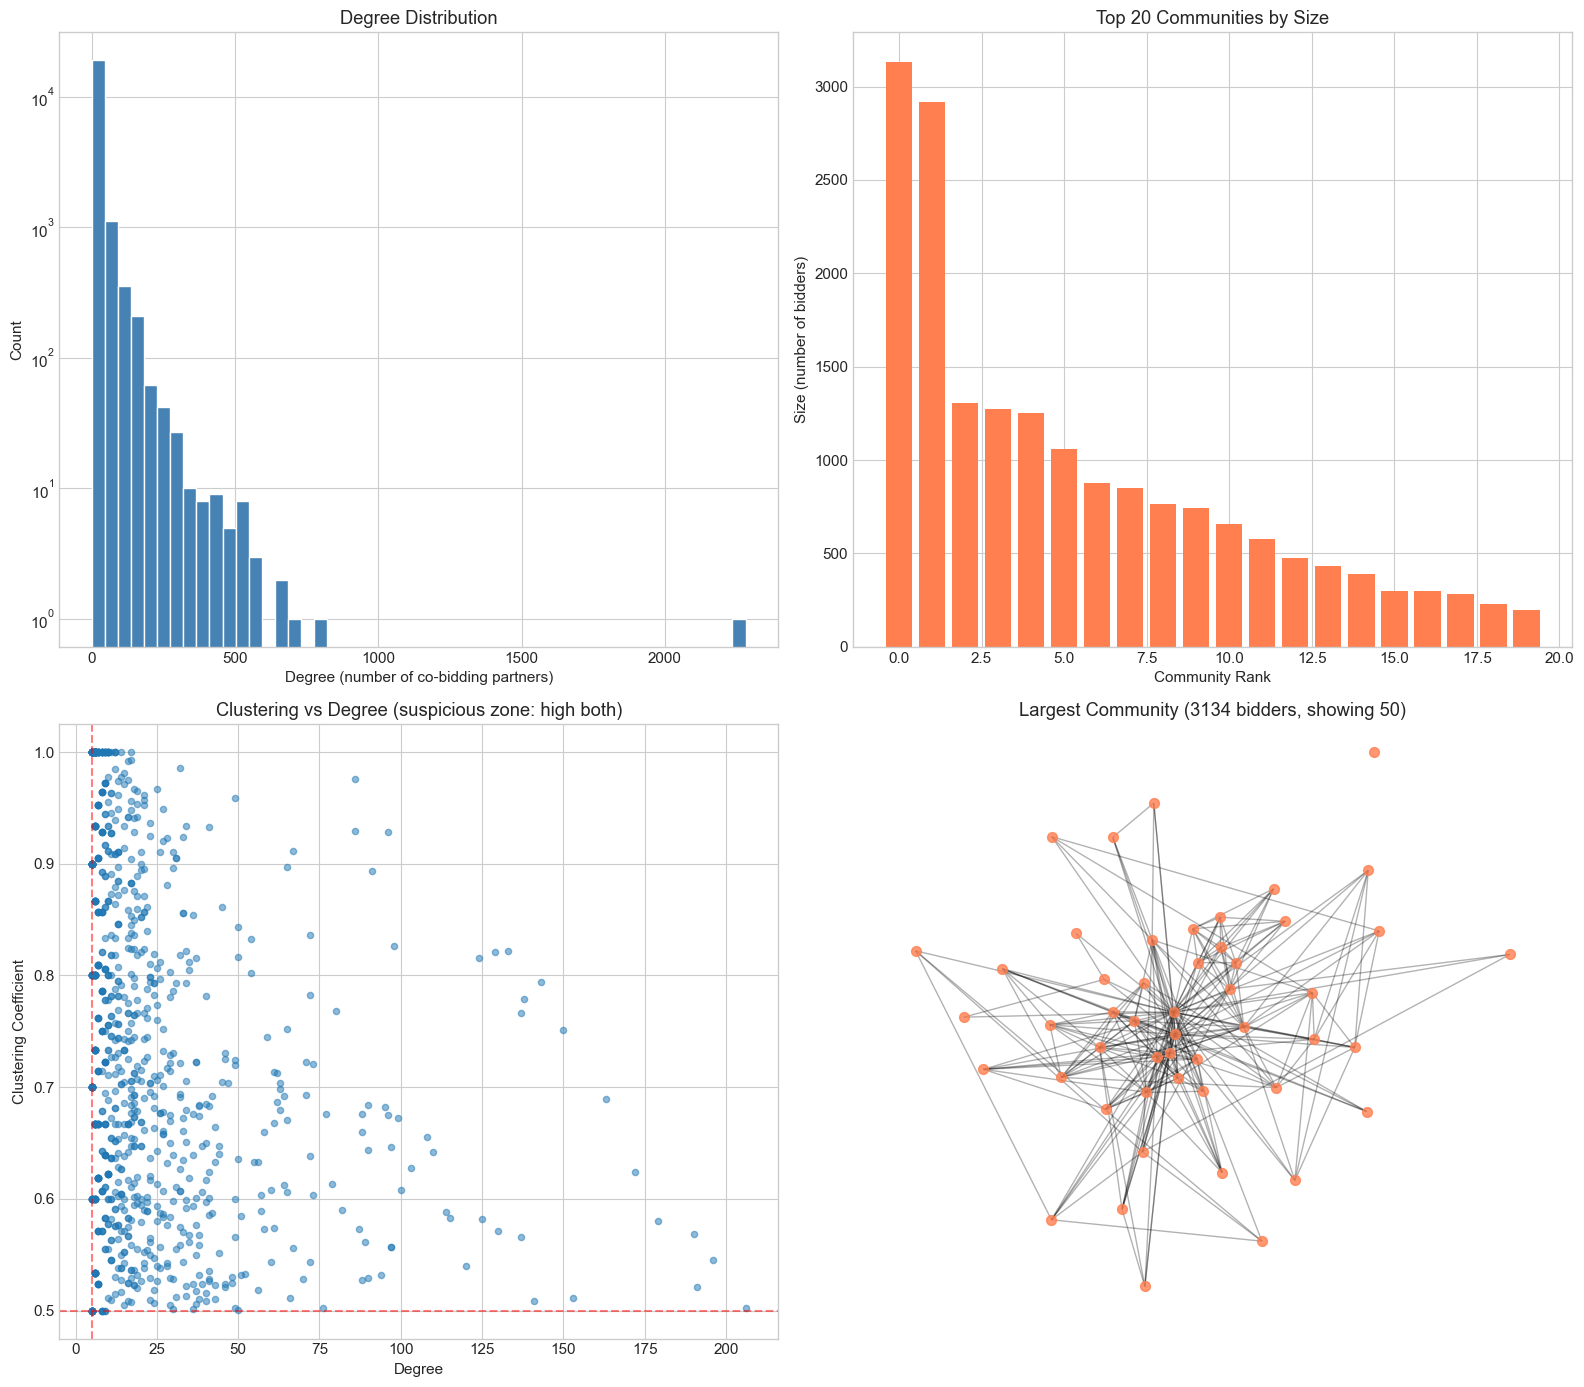

In [23]:
# Visualize co-bidding network analysis
print("Visualizing co-bidding network...")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Degree distribution
ax = axes[0, 0]
if len(degree_df) > 0:
    ax.hist(degree_df['degree'], bins=50, color='steelblue', edgecolor='white')
    ax.set_xlabel('Degree (number of co-bidding partners)')
    ax.set_ylabel('Count')
    ax.set_title('Degree Distribution')
    ax.set_yscale('log')
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center')

# Plot 2: Community size distribution
ax = axes[0, 1]
if len(community_counts) > 0:
    ax.bar(range(min(20, len(community_counts))), community_counts.head(20).values, color='coral')
    ax.set_xlabel('Community Rank')
    ax.set_ylabel('Size (number of bidders)')
    ax.set_title('Top 20 Communities by Size')
else:
    ax.text(0.5, 0.5, 'No communities', ha='center', va='center')

# Plot 3: Clustering vs Degree
ax = axes[1, 0]
if len(suspicious_bidders) > 0:
    sample = suspicious_bidders if len(suspicious_bidders) < 1000 else suspicious_bidders.sample(1000)
    ax.scatter(sample['degree'], sample['clustering'], alpha=0.5, s=20)
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
    ax.axvline(5, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Degree')
ax.set_ylabel('Clustering Coefficient')
ax.set_title('Clustering vs Degree (suspicious zone: high both)')

# Plot 4: Largest community subgraph
ax = axes[1, 1]
if partition and len(community_counts) > 0:
    top_community_ids = community_counts[community_counts >= 5].head(10).index.tolist()
    if len(top_community_ids) > 0:
        largest_comm_nodes = [n for n, c in partition.items() if c == top_community_ids[0]]
        subgraph = G_cobid.subgraph(largest_comm_nodes[:50])  # Limit for visualization
        
        pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
        nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color='coral', alpha=0.8, ax=ax)
        nx.draw_networkx_edges(subgraph, pos, alpha=0.3, ax=ax)
        ax.set_title(f'Largest Community ({len(largest_comm_nodes)} bidders, showing 50)')
ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/network/cobid_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Graph 2: Winner-Loser (Bid Rigging Detection)

**Вузли:** bidder_id  
**Ребра:** Направлені: Переможець → Програвший  
**Що виявляє:** Bid-rigging rings - якщо A завжди виграє у B, а B завжди виграє у C, а C у A

In [20]:
# Winner-Loser graph from detector
G_winlose = network_detector.G_winlose

if G_winlose is not None:
    print(f"Winner-Loser Graph:")
    print(f"  Nodes: {G_winlose.number_of_nodes():,}")
    print(f"  Edges (with {MIN_CO_BIDS}+ wins): {G_winlose.number_of_edges():,}")
else:
    print("Winner-Loser graph not built")

Winner-Loser Graph:
  Nodes: 15,633
  Edges (with 3+ wins): 95,300


In [19]:
# Bid rotation pairs from detector
rotation_df = network_detector.get_rotation_pairs(min_ratio=0.3)

print("BID ROTATION ANALYSIS:")
print("="*80)

if len(rotation_df) > 0:
    suspicious_rotation = rotation_df[rotation_df['rotation_ratio'] >= 0.5]
    
    print(f"\nBID ROTATION PAIRS (both win against each other):")
    print(f"Found: {len(suspicious_rotation)} suspicious pairs (rotation >= 50%)")
    
    for _, row in suspicious_rotation.head(10).iterrows():
        b1_name = suppliers[suppliers['supplier_id'] == row['bidder_1']]['supplier_name'].values
        b2_name = suppliers[suppliers['supplier_id'] == row['bidder_2']]['supplier_name'].values
        name1 = b1_name[0][:30] if len(b1_name) > 0 else 'N/A'
        name2 = b2_name[0][:30] if len(b2_name) > 0 else 'N/A'
        
        print(f"\n  Rotation: {row['rotation_ratio']:.0%}")
        print(f"    {name1} wins {row['wins_1_over_2']}x")
        print(f"    {name2} wins {row['wins_2_over_1']}x")
else:
    print("No reciprocal win-lose pairs found")

BID ROTATION ANALYSIS:

BID ROTATION PAIRS (both win against each other):
Found: 13615 suspicious pairs (rotation >= 50%)

  Rotation: 100%
    ФОП "ЯКІМЕЦЬ ГАЛИНА МИХАЙЛІВНА wins 3x
    ТОВ юлтис wins 3x

  Rotation: 100%
    ТОВ "СП ЮКОЙЛ" wins 4x
    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ wins 4x

  Rotation: 100%
    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ wins 5x
    ТОВ "ФУЕЛПОСТАЧ" wins 5x

  Rotation: 100%
    МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "ПР wins 6x
    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ wins 6x

  Rotation: 100%
    МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "ПР wins 4x
    ТОВ "УНІВЕРСАЛ ПРОМ ТРЕЙД" wins 4x

  Rotation: 100%
    ТОВ Рівненський заготівельно-в wins 3x
    ФОП КОВАЛЬ БОГДАН МИХАЙЛОВИЧ wins 3x

  Rotation: 100%
    ТОВ Рівненський заготівельно-в wins 3x
    ТОВ "АКВАТІНТА" wins 3x

  Rotation: 100%
    ТОВ "Е-ВЕНДОР" wins 4x
    ТОВ "ЕНЕРГІЯ-2024" wins 4x

  Rotation: 100%
    ФОП ТКАЧЕНКО МАРІЯ ВОЛОДИМИРІВ wins 4x
    ФОП ТАРАСОВА ОКСАНА МИКОЛАЇВНА wins 4x

  Rotation: 100%
    ТОВ Рівненський заго

In [20]:
# Find cycles (bid rigging rings)
print("Searching for bid rigging rings (cycles)...")

if G_winlose is not None and G_winlose.number_of_nodes() > 0:
    try:
        # Limit search to prevent memory issues
        cycles_3 = []
        for cycle in nx.simple_cycles(G_winlose, length_bound=3):
            if len(cycle) == 3:
                cycles_3.append(cycle)
            if len(cycles_3) >= 100:  # Limit
                break
        
        print(f"Found {len(cycles_3)} triangular rings (A→B→C→A)")
        
        if len(cycles_3) > 0:
            print("\nTOP 5 BID RIGGING RINGS:")
            for i, cycle in enumerate(cycles_3[:5]):
                print(f"\n  Ring {i+1}:")
                for bidder_id in cycle:
                    name = suppliers[suppliers['supplier_id'] == bidder_id]['supplier_name'].values
                    name = name[0][:40] if len(name) > 0 else 'N/A'
                    print(f"    - {name}")
    except Exception as e:
        print(f"Cycle detection skipped: {e}")
else:
    print("No winner-loser graph available")

Searching for bid rigging rings (cycles)...
Found 100 triangular rings (A→B→C→A)

TOP 5 BID RIGGING RINGS:

  Ring 1:
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    - ТОВ "ГРІНТЕКС"
    - ТОВ "СПЕКТРУМ ПЕКІДЖІНГ"

  Ring 2:
    - ДП "Жилком"
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 

  Ring 3:
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    - ПРИВАТНЕ ПІДПРИЄМСТВО "ФЕНІКС"
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 

  Ring 4:
    - ТОВ "НІКЕЛЬХРОМ УКРАЇНА"
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    - Товариство з обмеженою відповідальністю 

  Ring 5:
    - ТОВ «НВП «УКРБУДСЕРВІС»
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    - ПП "Українська сервісна бурова компанія-


## 4. Graph 3: Buyer-Supplier (Monopoly Detection)

**Вузли:** buyer_id, supplier_id  
**Ребра:** Контракт  
**Що виявляє:** Монопольні відносини, підозрілі зв'язки

In [19]:
# Buyer-Supplier graph from detector
G_bs = network_detector.G_buyer_supplier

if G_bs is not None:
    print(f"Buyer-Supplier Graph:")
    print(f"  Nodes: {G_bs.number_of_nodes():,}")
    print(f"  Edges: {G_bs.number_of_edges():,}")
else:
    print("Buyer-Supplier graph not built")

Buyer-Supplier Graph:
  Nodes: 198,182
  Edges: 916,277


In [22]:
# Monopolistic relationships from detector
monopolistic = network_detector.get_monopolistic_relationships()

print("Analyzing monopolistic relationships...")
print(f"\nMONOPOLISTIC RELATIONSHIPS (one supplier gets 80%+ contracts):")
print(f"Found: {len(monopolistic)} buyer-supplier pairs")

if len(monopolistic) > 0:
    monopolistic_with_names = monopolistic.head(10).merge(
        buyers[['buyer_id', 'buyer_name']], on='buyer_id', how='left'
    ).merge(
        suppliers[['supplier_id', 'supplier_name']], on='supplier_id', how='left'
    )
    
    for _, row in monopolistic_with_names.iterrows():
        buyer_name = row['buyer_name'][:30] if pd.notna(row.get('buyer_name')) else 'N/A'
        supplier_name = row['supplier_name'][:30] if pd.notna(row.get('supplier_name')) else 'N/A'
        print(f"\n  Dominance: {row['dominance_ratio']:.0%}, Value: {row['total_value']/1e6:.1f}M UAH")
        print(f"    Buyer: {buyer_name}")
        print(f"    Supplier: {supplier_name}")

Analyzing monopolistic relationships...

MONOPOLISTIC RELATIONSHIPS (one supplier gets 80%+ contracts):
Found: 5266 buyer-supplier pairs

  Dominance: 51%, Value: 7632.8M UAH
    Buyer: ДЕРЖАВНЕ ПІДПРИЄМСТВО МІНІСТЕР
    Supplier: Приховано

  Dominance: 99%, Value: 6576.3M UAH
    Buyer: Військова частина Т0160
    Supplier: Оборонний постачальник

  Dominance: 59%, Value: 3744.3M UAH
    Buyer: УПРАВЛІННЯ ІНФРАСТРУКТУРИ ВОЛИ
    Supplier: Оборонний постачальник

  Dominance: 76%, Value: 3038.8M UAH
    Buyer: Департамент капітального будів
    Supplier: Оборонний постачальник

  Dominance: 83%, Value: 1342.5M UAH
    Buyer: Військова частина Т0150
    Supplier: Оборонний постачальник

  Dominance: 94%, Value: 754.1M UAH
    Buyer: Квартирно-експлуатаційний відд
    Supplier: Оборонний постачальник

  Dominance: 85%, Value: 695.8M UAH
    Buyer: Військова частина А4123
    Supplier: Оборонний постачальник

  Dominance: 67%, Value: 633.9M UAH
    Buyer: Управління будівництва Вінниць
 

In [23]:
# Community detection in buyer-supplier network (separate analysis)
print("Detecting communities in buyer-supplier network...")

if G_bs is not None and G_bs.number_of_nodes() > 0:
    try:
        from community import community_louvain
        bs_partition = community_louvain.best_partition(G_bs, weight='weight')
    except ImportError:
        from networkx.algorithms.community import greedy_modularity_communities
        bs_communities = list(greedy_modularity_communities(G_bs, weight='weight'))
        bs_partition = {}
        for i, comm in enumerate(bs_communities):
            for node in comm:
                bs_partition[node] = i

    bs_community_counts = pd.Series(bs_partition).value_counts()

    print(f"Communities found: {len(bs_community_counts)}")
    print(f"Largest community: {bs_community_counts.iloc[0]} nodes")

    # Analyze mixed communities (buyers and suppliers together)
    print("\nAnalyzing community composition...")
    for comm_id in bs_community_counts.head(5).index:
        comm_nodes = [n for n, c in bs_partition.items() if c == comm_id]
        buyers_in_comm = [n for n in comm_nodes if n.startswith('B_')]
        suppliers_in_comm = [n for n in comm_nodes if n.startswith('S_')]
        print(f"  Community {comm_id}: {len(buyers_in_comm)} buyers, {len(suppliers_in_comm)} suppliers")
else:
    print("No buyer-supplier graph available")

Detecting communities in buyer-supplier network...
Communities found: 347
Largest community: 33162 nodes

Analyzing community composition...
  Community 0: 4172 buyers, 28990 suppliers
  Community 1: 2099 buyers, 10455 suppliers
  Community 2: 1822 buyers, 9768 suppliers
  Community 3: 1728 buyers, 8580 suppliers
  Community 4: 1563 buyers, 8146 suppliers


## 5. Summary & Export

In [24]:
print("="*60)
print("NETWORK ANALYSIS SUMMARY")
print("="*60)

print(f"\nDATASET:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Competitive tenders: {len(competitive_tenders):,}")
print(f"  Bids: {len(bids_competitive):,}")

# Summary from detector
summary = network_detector.summary()
print(f"\nGRAPH METRICS:")
for _, row in summary.iterrows():
    print(f"  {row['metric']}: {int(row['value']):,}")

print(f"\nKEY FINDINGS:")
if len(suspicious_bidders) > 0:
    print(f"  Suspicious bidders (high degree + clustering): {len(suspicious_bidders)}")
if len(rotation_df) > 0:
    print(f"  Bid rotation pairs: {len(rotation_df[rotation_df['rotation_ratio'] >= 0.5])}")
if len(monopolistic) > 0:
    print(f"  Monopolistic relationships: {len(monopolistic)}")

print("\n" + "="*60)

NETWORK ANALYSIS SUMMARY

DATASET:
  Tenders: 12,877,960
  Competitive tenders: 575,750
  Bids: 2,054,727

GRAPH METRICS:
  cobid_nodes: 20,894
  cobid_edges: 170,763
  communities: 836
  winlose_nodes: 15,633
  winlose_edges: 95,300
  rotation_pairs: 13,615
  monopolistic_pairs: 5,266
  full_collusion_nodes: 201,879
  full_collusion_edges: 1,087,106
  full_collusion_communities: 352
  mixed_communities: 114
  flagged_tenders: 2,296,664

KEY FINDINGS:
  Suspicious bidders (high degree + clustering): 5394
  Bid rotation pairs: 13615
  Monopolistic relationships: 5266



In [25]:
# Export results
print("Saving results...")

# 1. Network results (tender-level)
network_results.to_csv('../results/network_results.csv', index=False)
print(f"Saved: network_results.csv ({len(network_results)} rows)")

# 2. Suspicious bidders (high connectivity)
if len(suspicious_bidders) > 0:
    suspicious_export = suspicious_bidders.merge(
        suppliers[['supplier_id', 'supplier_name']].rename(columns={'supplier_id': 'bidder_id'}),
        on='bidder_id', how='left'
    )
    suspicious_export['community'] = suspicious_export['bidder_id'].map(partition)
    suspicious_export.to_csv('../results/network_suspicious_bidders.csv', index=False)
    print(f"Saved: network_suspicious_bidders.csv ({len(suspicious_export)} rows)")

# 3. Bid rotation pairs
if len(rotation_df) > 0:
    rotation_export = rotation_df[rotation_df['rotation_ratio'] >= 0.3].copy()
    rotation_export = rotation_export.merge(
        suppliers[['supplier_id', 'supplier_name']].rename(
            columns={'supplier_id': 'bidder_1', 'supplier_name': 'bidder_1_name'}
        ), on='bidder_1', how='left'
    ).merge(
        suppliers[['supplier_id', 'supplier_name']].rename(
            columns={'supplier_id': 'bidder_2', 'supplier_name': 'bidder_2_name'}
        ), on='bidder_2', how='left'
    )
    rotation_export.to_csv('../results/network_bid_rotation.csv', index=False)
    print(f"Saved: network_bid_rotation.csv ({len(rotation_export)} rows)")

# 4. Monopolistic relationships
if len(monopolistic) > 0:
    monopolistic_export = monopolistic.merge(
        buyers[['buyer_id', 'buyer_name']], on='buyer_id', how='left'
    ).merge(
        suppliers[['supplier_id', 'supplier_name']], on='supplier_id', how='left'
    )
    monopolistic_export.to_csv('../results/network_monopolistic.csv', index=False)
    print(f"Saved: network_monopolistic.csv ({len(monopolistic_export)} rows)")

# 5. Community assignments
if cobid_metrics is not None and len(cobid_metrics) > 0:
    community_export = cobid_metrics.copy()
    community_export['community'] = community_export['bidder_id'].map(partition)
    community_export = community_export.merge(
        suppliers[['supplier_id', 'supplier_name']].rename(columns={'supplier_id': 'bidder_id'}),
        on='bidder_id', how='left'
    )
    community_export.to_csv('../results/network_communities.csv', index=False)
    print(f"Saved: network_communities.csv ({len(community_export)} rows)")

print("\nDone!")

Saving results...
Saved: network_results.csv (12877960 rows)
Saved: network_suspicious_bidders.csv (5394 rows)
Saved: network_bid_rotation.csv (18126 rows)
Saved: network_monopolistic.csv (5266 rows)
Saved: network_communities.csv (20894 rows)

Done!


## Висновки

### Що виявлено:

1. **Co-bidding Network**
   - Communities = потенційні картелі
   - High clustering + degree = тісно пов'язані групи
   - ~~Betweenness centrality~~ — непридатна через фрагментацію графу (836 компонент)

2. **Winner-Loser Network**
   - Reciprocal edges (A beats B AND B beats A) = bid rotation
   - Cycles = bid rigging rings

3. **Buyer-Supplier Network**
   - Monopolistic relationships = один supplier домінує
   - Communities = групи пов'язаних buyers та suppliers

## 6. Full Collusion Graph - Mixed Communities Analysis (Optional)

**Mixed communities** — спільноти де buyers і suppliers тісно пов'язані через різні типи зв'язків (контракти, co-bidding, win-lose). Це може вказувати на комплексні схеми змови.

> **Note:** Set `BUILD_FULL_COLLUSION = True` in configuration to enable this analysis.

In [17]:
# Analyze Full Collusion Graph mixed communities
if not BUILD_FULL_COLLUSION:
    print("Full Collusion Graph analysis skipped (BUILD_FULL_COLLUSION = False)")
    print("Set BUILD_FULL_COLLUSION = True in configuration to enable.")
    mixed_df = pd.DataFrame()
else:
    print("Analyzing Full Collusion Graph communities...")
    
    G_full = network_detector.G_full_collusion
    full_communities = network_detector.full_collusion_communities
    
    if full_communities:
        # Count community sizes
        full_comm_counts = pd.Series(full_communities).value_counts()
        
        print(f"\nFull Collusion Graph:")
        print(f"  Total communities: {len(full_comm_counts)}")
        print(f"  Largest community: {full_comm_counts.iloc[0]} nodes")
        
        # Analyze mixed communities (contain both B_ and S_ nodes)
        mixed_communities_data = []
        
        for comm_id in full_comm_counts.index:
            comm_nodes = [n for n, c in full_communities.items() if c == comm_id]
            buyers_in = [n for n in comm_nodes if str(n).startswith('B_')]
            suppliers_in = [n for n in comm_nodes if str(n).startswith('S_')]
            
            if len(buyers_in) > 0 and len(suppliers_in) > 0:
                # Get subgraph for this community
                subgraph = G_full.subgraph(comm_nodes)
                
                # Calculate total contract value in community (edge_type, not type)
                total_value = sum(
                    d.get('weight', 0) for u, v, d in subgraph.edges(data=True)
                    if d.get('edge_type') == 'contract'
                )
                
                # Count edge types
                contract_edges = sum(1 for u, v, d in subgraph.edges(data=True) if d.get('edge_type') == 'contract')
                cobid_edges = sum(1 for u, v, d in subgraph.edges(data=True) if d.get('edge_type') == 'cobid')
                winlose_edges = sum(1 for u, v, d in subgraph.edges(data=True) if d.get('edge_type') == 'winlose')
                
                mixed_communities_data.append({
                    'community_id': comm_id,
                    'total_nodes': len(comm_nodes),
                    'buyers': len(buyers_in),
                    'suppliers': len(suppliers_in),
                    'total_edges': subgraph.number_of_edges(),
                    'contract_edges': contract_edges,
                    'cobid_edges': cobid_edges,
                    'winlose_edges': winlose_edges,
                    'total_value': total_value,
                })
        
        mixed_df = pd.DataFrame(mixed_communities_data)
        mixed_df = mixed_df.sort_values('total_value', ascending=False)
        
        print(f"\nMixed communities (buyers + suppliers): {len(mixed_df)}")
        print(f"\nTop 10 by contract value:")
        display(mixed_df.head(10))
    else:
        print("No full collusion communities available")
        mixed_df = pd.DataFrame()

Analyzing Full Collusion Graph communities...

Full Collusion Graph:
  Total communities: 364
  Largest community: 42906 nodes

Mixed communities (buyers + suppliers): 332

Top 10 by contract value:


,community_id,total_nodes,buyers,suppliers,total_edges,contract_edges,cobid_edges,winlose_edges,total_value
0,0,42906,5622,37284,155448,131050,24366,32,1249791
1,3,13079,2094,10985,48234,47298,936,0,599535
3,16,9207,1421,7786,35690,34902,788,0,526942
6,15,7649,990,6659,27658,27328,330,0,480059
8,13,7294,899,6395,26186,25943,243,0,467149
4,8,8276,1684,6592,30953,30817,136,0,443075
9,12,6866,1279,5587,26950,26817,133,0,413095
7,2,7489,1401,6088,31618,29735,1882,1,401414
10,19,6115,960,5155,23430,23035,395,0,375055
5,7,8224,1285,6939,29854,29691,163,0,358769


In [18]:
# Deep dive into suspicious mixed communities (small but high value)
if not BUILD_FULL_COLLUSION or len(mixed_df) == 0:
    suspicious_mixed = pd.DataFrame()
    if BUILD_FULL_COLLUSION:
        print("No mixed communities to analyze")
else:
    # Suspicious = small community but high value (concentrated relationships)
    mixed_df['value_per_node'] = mixed_df['total_value'] / (mixed_df['total_nodes'] + 1e-10)
    
    # Filter: communities with actual contract value
    valued_communities = mixed_df[mixed_df['total_value'] > 0]
    print(f"Communities with contract value > 0: {len(valued_communities)}")
    
    suspicious_mixed = valued_communities[
        (valued_communities['total_nodes'] <= 50) &  # Small/medium community
        (valued_communities['total_value'] > 1e7)     # High value (>10M UAH)
    ].sort_values('value_per_node', ascending=False)
    
    print(f"\nSUSPICIOUS MIXED COMMUNITIES (small size + high value):")
    print(f"Found: {len(suspicious_mixed)}")
    
    if len(suspicious_mixed) > 0:
        for _, row in suspicious_mixed.head(5).iterrows():
            print(f"\n  Community {row['community_id']}:")
            print(f"    Nodes: {row['total_nodes']} ({row['buyers']} buyers, {row['suppliers']} suppliers)")
            print(f"    Edges: {row['contract_edges']} contracts, {row['cobid_edges']} co-bids, {row['winlose_edges']} win-lose")
            print(f"    Total value: {row['total_value']/1e6:.1f}M UAH")
            print(f"    Value/node: {row['value_per_node']/1e6:.1f}M UAH")
            
            # Get participants
            full_communities = network_detector.full_collusion_communities
            comm_nodes = [n for n, c in full_communities.items() if c == row['community_id']]
            buyer_nodes = [n for n in comm_nodes if str(n).startswith('B_')]
            supplier_nodes = [n for n in comm_nodes if str(n).startswith('S_')]
            
            print("    Buyers:")
            for bn in buyer_nodes[:3]:
                buyer_id = int(str(bn).replace('B_', ''))
                name = buyers[buyers['buyer_id'] == buyer_id]['buyer_name'].values
                name = name[0][:50] if len(name) > 0 else 'N/A'
                print(f"      - {name}")
            if len(buyer_nodes) > 3:
                print(f"      ... and {len(buyer_nodes) - 3} more")
            
            print("    Suppliers:")
            for sn in supplier_nodes[:3]:
                supplier_id = int(str(sn).replace('S_', ''))
                name = suppliers[suppliers['supplier_id'] == supplier_id]['supplier_name'].values
                name = name[0][:50] if len(name) > 0 else 'N/A'
                print(f"      - {name}")
            if len(supplier_nodes) > 3:
                print(f"      ... and {len(supplier_nodes) - 3} more")

Communities with contract value > 0: 332

SUSPICIOUS MIXED COMMUNITIES (small size + high value):
Found: 0


In [ ]:
# Save mixed communities analysis (only if Full Collusion Graph was built)
if BUILD_FULL_COLLUSION and len(mixed_df) > 0:
    mixed_df.to_csv('../results/network_full_collusion_communities.csv', index=False)
    print(f"Saved: network_full_collusion_communities.csv ({len(mixed_df)} communities)")
    
    if len(suspicious_mixed) > 0:
        suspicious_mixed.to_csv('../results/network_suspicious_mixed_communities.csv', index=False)
        print(f"Saved: network_suspicious_mixed_communities.csv ({len(suspicious_mixed)} communities)")
else:
    print("Full Collusion Graph results not saved (disabled or empty)")